# Analysis on Loh Kean Yew's Meteoric Rise

Inspired by Loh Kean Yew's historic achievement of being the first Singaporean to win a BWF World Championships title at the BWF World Championships 2021 held in Huelva, Spain, I wanted to do some simple analysis on his meteoric rise to the top of the badminton world.

## Table of Content

* [Exploring Data](#chapter1)
    * [Cleaning the Tournament Round Data](#section1.1)
    * [Investigating Match Time](#section1.2)
    * [Investigating Scores](#section1.3)
    * [Transform data to make Loh Kean Yew as Player 1](#section1.4)
    * [Formatting Win/Lose data](#section1.5)
* [Performance Analysis](#chapter2)    
    * [General Performance](#section2.1)
    * [Wins and Losses](#section2.2)    
* [Conclusion](#chapter3)     

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
import seaborn as sns
import re
import math

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.options.display.max_columns = None

## Exploring Data <a class="anchor" id="chapter1"></a>

The data was scraped from the [BWF official website](https://bwfbadminton.com/player/76115/loh-kean-yew). Of interest to us are the players data, of which we can access the tournament results and matches history. For Loh Kean Yew, we are able to gather his matches history from 2012 to 2021.

In [2]:
lky = pd.read_csv('bwf_lky.csv', index_col = 0)

In [3]:
lky.head()

,year,tournament,round,match_time,player1,player2,player1_set1,player2_set1,player1_set2,player2_set2,player1_set3,player2_set3
0,2021,TotalEnergies BWF World Championships 2021,R64,0:54,LOH Kean Yew,Viktor AXELSEN,14,21,21.0,9.0,21.0,6.0
1,2021,TotalEnergies BWF World Championships 2021,R32,0:25,Luka WRABER,LOH Kean Yew,4,21,8.0,21.0,NaN,NaN
2,2021,TotalEnergies BWF World Championships 2021,R16,0:30,Kantaphon WANGCHAROEN,LOH Kean Yew,4,21,7.0,21.0,NaN,NaN
3,2021,TotalEnergies BWF World Championships 2021,QF,0:43,PRANNOY H. S.,LOH Kean Yew,14,21,12.0,21.0,NaN,NaN
4,2021,TotalEnergies BWF World Championships 2021,SF,1:01,Anders ANTONSEN,LOH Kean Yew,21,23,14.0,21.0,NaN,NaN


In [4]:
lky.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 223 entries, 0 to 222
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          223 non-null    int64  
 1   tournament    223 non-null    object 
 2   round         212 non-null    object 
 3   match_time    223 non-null    object 
 4   player1       223 non-null    object 
 5   player2       223 non-null    object 
 6   player1_set1  218 non-null    object 
 7   player2_set1  217 non-null    object 
 8   player1_set2  212 non-null    float64
 9   player2_set2  214 non-null    float64
 10  player1_set3  79 non-null     float64
 11  player2_set3  79 non-null     float64
dtypes: float64(4), int64(1), object(7)
memory usage: 22.6+ KB


We see that there are a total of 223 matches data. Notably, there are `null` data in `round`, `player1_set1`, `player2_set1`, `player1_set2`, `player2_set2`, `player1_set3`, `player2_set3`.

We know that for example `player1_set1` refers to the first set score for player 1. There could be `null` score for some matches when there are bye/walkover. We will investigate this further.

In addition, if a player had already won two straight sets, there would no need be for a third set. Hence, it is understandable why set 3 had significantly more `null` values.

To summarise the required data cleaning work:
* Check on `null` value in `round`.
* Check on the `null` values for each of the sets.
* Check on the discrepancy in `null` values within each set (e.g. set 1 had 218 entries for player 1 but 217 entries for player 2).
* Transform the set score to as some are `object` and some are `float64`. Set score should be `int` type.

## Cleaning the Tournament Round Data <a class="anchor" id="section1.1"></a>

In [5]:
lky['round'].unique()

array(['R64', 'R32', 'R16', 'QF', 'SF', 'Final', 'Group G', 'R1', 'R2',
       'Qual. R16', 'R3', 'Qual. QF', '3/4', 'Qual. R64', 'Qual. R32',
       nan, 'R128'], dtype=object)

In the dataset, these are the values under `round`, which we could consider to use to replace the `null` values.

Also note that there is some inconsistency in the labelling, for e.g. 'R64' vs 'Qual. R64'. We should just clean and remove 'Qual' subsequently.

In [6]:
lky[lky['round'].isnull()]

,year,tournament,round,match_time,player1,player2,player1_set1,player2_set1,player1_set2,player2_set2,player1_set3,player2_set3
135,2017,ROBOT Badminton Asia Mixed Team Championships ...,NaN,0:34,Sameer VERMA,LOH Kean Yew,21,9,21.0,16.0,NaN,NaN
149,2016,Happening Hyderabad Badminton Asia Team Champi...,NaN,0:40,WANG Zhengming,LOH Kean Yew,15,21,16.0,21.0,NaN,NaN
150,2016,Happening Hyderabad Badminton Asia Team Champi...,NaN,0:29,Ajay JAYARAM,LOH Kean Yew,21,11,21.0,18.0,NaN,NaN
159,2015,World Junior Mixed Team Championships 2015,NaN,0:21,LOH Kean Yew,James ELLAWAY,21,12,21.0,8.0,NaN,NaN
160,2015,World Junior Mixed Team Championships 2015,NaN,0:16,LOH Kean Yew,Diego CASTILLO,21,5,21.0,11.0,NaN,NaN
161,2015,World Junior Mixed Team Championships 2015,NaN,0:34,Firman Abdul KHOLIK,LOH Kean Yew,21,10,21.0,14.0,NaN,NaN
162,2015,World Junior Mixed Team Championships 2015,NaN,0:21,LOH Kean Yew,Manuel BREA FILLOY,21,9,21.0,14.0,NaN,NaN
163,2015,World Junior Mixed Team Championships 2015,NaN,0:22,Felix HAMMES,LOH Kean Yew,12,21,12.0,21.0,NaN,NaN
177,2015,SCG Badminton Asia Junior Championships 2015,NaN,0:35,LOH Kean Yew,Satheishtharan RAMACHANDRAN,19,21,12.0,21.0,NaN,NaN
178,2015,SCG Badminton Asia Junior Championships 2015,NaN,0:39,Seung Hoon LEE,LOH Kean Yew,17,21,17.0,21.0,NaN,NaN


We notice that `round` with `null` value usually occurs for a select few tournaments:
* ROBOT Badminton Asia Mixed Team Championships 2017
* Happening Hyderabad Badminton Asia Team Championships 2016
* World Junior Mixed Team Championships 2015
* SCG Badminton Asia Junior Championships 2015
* VIVO BWF Sudirman Cup 2015

We will do a cross check to understand more about the above few tournaments and decide how to manage these `null` values.

* For the [ROBOT Badminton Asia Mixed Team Championships 2017](https://en.wikipedia.org/wiki/2017_Badminton_Asia_Mixed_Team_Championships), Singapore was eliminated at Singapore was eliminated at the Group stage and did not progress to the knockout stage. We can label this match as Group.


* For the [Happening Hyderabad Badminton Asia Team Championships 2016](https://en.wikipedia.org/wiki/2016_Badminton_Asia_Team_Championships), Singapore was eliminated at the Group stage and did not progress to the knockout stage. We can label these matches as Group.


* For the [World Junior Mixed Team Championships 2015](https://en.wikipedia.org/wiki/2015_BWF_World_Junior_Championships_%E2%80%93_Teams_event), is the Teams event of the 2015 BWF World Junior Championships. Singapore achieved a final team ranking of 11th place. As it is not a typical playoff format, we will label these matches as Group or remove them altogether.


* For the [SCG Badminton Asia Junior Championships 2015](https://en.wikipedia.org/wiki/2015_Badminton_Asia_Junior_Championships), Loh Kean Yew made it to the fourth round before elimination. This was before progression to the quarter-finals, hence we can label this as the Round of 32.


* For the [VIVO BWF Sudirman Cup 2015](https://en.wikipedia.org/wiki/Sudirman_Cup), Sudirman Cup is a unique international competition that does not stage a qualification round. The competing teams are divided into 7 groups based on their performances. Only teams in Group 1 will have a chance to lift the trophy as the teams in other groups fight for promotion. Singapore was eliminated after Round 1. Hence, we can possibly label this match round as Group.

### Replacing the `null` values with the decided appropriate values

In [7]:
lky['round'].unique()

array(['R64', 'R32', 'R16', 'QF', 'SF', 'Final', 'Group G', 'R1', 'R2',
       'Qual. R16', 'R3', 'Qual. QF', '3/4', 'Qual. R64', 'Qual. R32',
       nan, 'R128'], dtype=object)

In [8]:
lky.loc[177:178,'round'] = 'R32'

In [9]:
lky.loc[177:178]

,year,tournament,round,match_time,player1,player2,player1_set1,player2_set1,player1_set2,player2_set2,player1_set3,player2_set3
177,2015,SCG Badminton Asia Junior Championships 2015,R32,0:35,LOH Kean Yew,Satheishtharan RAMACHANDRAN,19,21,12.0,21.0,NaN,NaN
178,2015,SCG Badminton Asia Junior Championships 2015,R32,0:39,Seung Hoon LEE,LOH Kean Yew,17,21,17.0,21.0,NaN,NaN


In [10]:
#getting the list of row index that have null value in round
round_null = lky[lky['round'].isnull()].index.tolist()
round_null

[135, 149, 150, 159, 160, 161, 162, 163, 179]

In [11]:
lky.loc[round_null, 'round'] = 'Group'

### Cleaning up values with discrepancies

Now that are done with cleaning up the `null` values, there are a few additional steps to check and clean up
1. All group-related round should be designed as just 'Group'. E.g. To convert 'Group G' to 'Group'.
2. Remove 'Qual', for example from 'Qual. QF' and keep just 'QF'.
3. Check on what is 'R1', 'R2' and '3/4' and clean them up accordingly

In [12]:
lky['round'].unique()

array(['R64', 'R32', 'R16', 'QF', 'SF', 'Final', 'Group G', 'R1', 'R2',
       'Qual. R16', 'R3', 'Qual. QF', '3/4', 'Qual. R64', 'Qual. R32',
       'Group', 'R128'], dtype=object)

In [13]:
lky['round'].value_counts()

R32          54
R64          43
R16          35
QF           22
SF           15
Final        14
Qual. R16    11
Group         9
R1            5
Qual. QF      3
R3            3
Qual. R32     2
Group G       2
R2            2
Qual. R64     1
R128          1
3/4           1
Name: round, dtype: int64

#### Step 1: Convert Group-Related Round

In [14]:
lky[lky['round'] == 'Group G']

,year,tournament,round,match_time,player1,player2,player1_set1,player2_set1,player1_set2,player2_set2,player1_set3,player2_set3
26,2021,Tokyo 2020 Olympic Games Badminton,Group G,0:33,LOH Kean Yew,Aram MAHMOUD,21,15,21.0,12.0,NaN,NaN
27,2021,Tokyo 2020 Olympic Games Badminton,Group G,1:08,Jonatan CHRISTIE,LOH Kean Yew,22,20,13.0,21.0,21.0,18.0


In [15]:
lky.loc[26:27, 'round'] = 'Group'

#### Step 2: Remove 'Qual'

In [16]:
lky['round'] = lky['round'].str.replace("Qual. ", "")

#### Step 3: Investigate Anomalies

In [17]:
#The following are anomalies: R1, R3, R2, 3/4

lky[lky['round'].isin(['R1', 'R3', 'R2', '3/4'])]

,year,tournament,round,match_time,player1,player2,player1_set1,player2_set1,player1_set2,player2_set2,player1_set3,player2_set3
31,2020,Badminton Asia Team Championships 2020,R1,0:26,LOH Kean Yew,Ros Leonard PEDROSA,21,11,21.0,8.0,NaN,NaN
32,2020,Badminton Asia Team Championships 2020,R2,0:41,CHOU Tien Chen,LOH Kean Yew,16,21,17.0,21.0,NaN,NaN
60,2019,TOTAL BWF Sudirman Cup 2019,R1,0:36,Brian YANG,LOH Kean Yew,18,21,15.0,21.0,NaN,NaN
61,2019,TOTAL BWF Sudirman Cup 2019,R3,0:38,Alexander ROOVERS,LOH Kean Yew,13,21,16.0,21.0,NaN,NaN
62,2019,TOTAL BWF Sudirman Cup 2019,R1,1:02,Tien Minh NGUYEN,LOH Kean Yew,21,16,18.0,21.0,21.0,23.0
66,2019,Tong Yun Kai Cup 2019,R3,0:55,WANG Tzu Wei,LOH Kean Yew,21,15,13.0,21.0,13.0,21.0
67,2019,Tong Yun Kai Cup 2019,R1,0:53,PRANNOY H. S.,LOH Kean Yew,21,8,12.0,21.0,21.0,17.0
113,2018,2018 Commonwealth Games,R2,0:30,LOH Kean Yew,Georges Julien PAUL,21,14,21.0,15.0,NaN,NaN
116,2018,2018 Commonwealth Games,3/4,1:07,LOH Kean Yew,Rajiv OUSEPH,22,20,15.0,21.0,23.0,25.0
144,2016,Dong Feng Citroen Badminton Asia Championships...,R1,0:20,LOH Kean Yew,Pang Fong PUI,21,10,21.0,8.0,NaN,NaN


The Badminton Asia Team Championships 2020, TOTAL BWF Sudirman Cup 2019, and Tong Yun Kai Cup 2019 are all team championships and the R1/R2/R3 represents the Group stage.

For Dong Feng Citroen Badminton Asia Championships 2016, R1 and R3 are the round robin matches in the Group stage.

For 2018 Commonwealth Games, R2 represents the Group stage, while 3/4 represents the 3rd/4th placing playoffs. Since there is only one instance in our tournament data, we will tag it similar to a semi-final (SF).

In [18]:
lky['round'] = lky['round'].str.replace(r"R1$", "Group")
lky['round'] = lky['round'].str.replace(r"R2$", "Group")
lky['round'] = lky['round'].str.replace(r"R3$", "Group")

In [19]:
lky['round'] = lky['round'].str.replace(r"3/4", "SF")

Because there is only one instance of R128, we will reclassify it as Group stage so that it is more meaningful for analysis subsequently.

In [20]:
lky['round'] = lky['round'].str.replace(r"R128", "Group")

In [21]:
lky['round'].value_counts()

R32      56
R16      46
R64      44
QF       25
Group    22
SF       16
Final    14
Name: round, dtype: int64

## Investigating Match Time <a class="anchor" id="section1.2"></a>

In [22]:
lky['match_time'] = pd.to_datetime(lky['match_time'], format = '%H:%M')

In [23]:
lky['match_time'] = lky['match_time'].apply(lambda x: x.minute + 60 if x.hour == 1 
                              else x.minute)

### Match time that are not realistic

Realistically, a match time should not be less than five minutes, unless due to special circumstances such as early retirement, or a bye/walkover.

In [24]:
lky[lky['match_time'] < 5]

,year,tournament,round,match_time,player1,player2,player1_set1,player2_set1,player1_set2,player2_set2,player1_set3,player2_set3
39,2019,30th SEA GAMES 2019 (Individual Event),Final,0,LOH Kean Yew,LEE Zii Jia,NaN,NaN,NaN,NaN,NaN,NaN
47,2019,IDBI Federal Life Insurance Hyderabad Open 2019,R32,1,Sony Dwi KUNCORO,LOH Kean Yew,2,2,NaN,NaN,NaN,NaN
52,2019,Russian Open 2019,R64,0,LOH Kean Yew,Walkover/Bye,BYE,BYE,NaN,NaN,NaN,NaN
119,2018,Austrian Open 2018,R64,0,Joran KWEEKEL,LOH Kean Yew,NaN,NaN,NaN,NaN,NaN,NaN
168,2015,Kawasaki - Tran Local Foods Vietnam Internatio...,R64,0,LOH Kean Yew,Walkover/Bye,BYE,BYE,NaN,NaN,NaN,NaN
204,2014,USM International Series 2014,R32,0,LOH Kean Yew,Vero Wisnu Kusuma WARDANA,BYE,13,NaN,6.0,NaN,NaN
205,2014,USM International Series 2014,R64,0,LOH Kean Yew,Yobellto Rendy ISMANTO,BYE,14,NaN,15.0,NaN,NaN
206,2014,USM International Series 2014,R16,0,Senatria Agus SETIA PUTRA,LOH Kean Yew,21,NaN,13.0,NaN,21.0,NaN
215,2013,Prim-A Indonesia International Challenge 2013,R64,0,LOH Kean Yew,Jonatan CHRISTIE,BYE,21,NaN,19.0,NaN,21.0


For the 30th SEA GAMES 2019, it is not typical that a final game is a bye/walkover. Upon further investigation, we found that the [game](https://en.wikipedia.org/wiki/Badminton_at_the_2019_Southeast_Asian_Games_%E2%80%93_Individual_event#Men's_singles) did take place and the match data was not captured in the BWF website. Loh Kean Yew lost the game in straight sets of (18-21, 18-21). We will update the score data manually, but were not able to find the match time.

For the IDBI Federal Life Insurance Hyderabad Open 2019 [game](https://en.wikipedia.org/wiki/2019_Hyderabad_Open_(badminton)), it was an early retirement from the opponent. We will remove this match since it does not really represent Loh Kean Yew's performance.

For the Austrian Open 2018, it was a walkover.

For the USM International Series 2014 and Prim-A Indonesia International Challenge 2013, it is peculiar as it was listed as bye, but at the same time there were scores for the opponents. By referring to separate [website 1](https://bwf.tournamentsoftware.com/sport/player.aspx?id=735922B2-05F6-40AE-AF96-CBA5ED634A82&player=133) and [website 2](https://bwf.tournamentsoftware.com/sport/player.aspx?id=9E5D53EC-FF4F-438D-B06E-251A3B7A747F&player=110), we found that the match data were not recorded accurately on the BWF website. We will update the score data manually, but were not able to find the match time.

### Removing Early Retirement Scores

In [25]:
lky = lky.drop(index = 47)

### Updating the Scores

Earlier we noticed the peculiarity where there are set scores listed as bye, but at the same time there were scores for the opponents. By cross checking with other sources, we found that these were errors on the BWF website. We will cross reference and correct them manually.

We will need to update and correct the scores first, as we will use it as a criteria for approximating match time.

In [26]:
#define a function that can update the scores given a list
def update_score(x):
    index = x[0]
    lky.loc[index, 'player1_set1'] = x[1]
    lky.loc[index, 'player2_set1'] = x[2]
    lky.loc[index, 'player1_set2'] = x[3]
    lky.loc[index, 'player2_set2'] = x[4]
    
    #only update if there are third set scores
    if len(x) > 5:
        lky.loc[index, 'player1_set3'] = x[5]
        lky.loc[index, 'player2_set3'] = x[6]

In [27]:
scorelist_lzj = [39, '18', '21', '18', '21']
scorelist_wardana = [204, '21', '13', '21', '6']
scorelist_ismantao = [205, '21', '14', '21', '15']
scorelist_senatria = [206, '21', '13', '13', '21', '21', '10']
scorelist_christie = [215, '14', '21', '21', '19', '15', '21']

update_score(scorelist_lzj)
update_score(scorelist_wardana)
update_score(scorelist_ismantao)
update_score(scorelist_senatria)
update_score(scorelist_christie)

### Approximate the match time

Since there is no match time available for some of the matches, we will use the other finals match time with similar scoreline (the closer the scoreline, the longer it takes due to back and forth) and the number of sets played (in general three sets will take longer than straight sets) to approximate.

In [28]:
#define a function to approximate the match time from other similar matches
#referencing similar matches based on the number of sets played, the total scores across all the sets
#as there may be limited matches with the same total scores, we will have a margin of plus minus 2
def approx_matchtime(index):
    
    #three sets
    if pd.notnull(lky.loc[index, 'player1_set3']):
        sum_pts = lky.loc[index,'player1_set1':'player2_set3'].astype(int).sum()
        third_sets = lky[(pd.notnull(lky['player1_set3'])) & (lky['match_time'] != 0)].copy()
        third_sets.loc[:,'player1_set1':'player2_set3'] = third_sets.loc[:,'player1_set1':'player2_set3'].astype(int)
        third_sets['total_pts'] = third_sets.loc[:,'player1_set1':'player2_set3'].sum(axis=1)
        return round(third_sets[(third_sets['total_pts'] >= sum_pts-2) & 
                                (third_sets['total_pts'] <= sum_pts+2)]['match_time'].mean())
    #two sets    
    else:
        sum_pts = lky.loc[index,'player1_set1':'player2_set2'].astype(int).sum()
        two_sets = lky[(pd.isnull(lky['player1_set3'])) & (pd.notnull(lky['player1_set2'])) & (lky['match_time'] != 0)].copy()
        two_sets.loc[:,'player1_set1':'player2_set2'] = two_sets.loc[:,'player1_set1':'player2_set2'].astype(int)
        two_sets['total_pts'] = two_sets.loc[:,'player1_set1':'player2_set2'].sum(axis=1)
        return round(two_sets[(two_sets['total_pts'] >= sum_pts-2) & 
                              (two_sets['total_pts'] <= sum_pts+2)]['match_time'].mean())

In [29]:
lky.loc[39, 'match_time'] = approx_matchtime(39)
lky.loc[204, 'match_time'] = approx_matchtime(204)
lky.loc[205, 'match_time'] = approx_matchtime(205)
lky.loc[206, 'match_time'] = approx_matchtime(206)
lky.loc[215, 'match_time'] = approx_matchtime(215)

In [30]:
lky.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 222 entries, 0 to 222
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   year          222 non-null    int64 
 1   tournament    222 non-null    object
 2   round         222 non-null    object
 3   match_time    222 non-null    int64 
 4   player1       222 non-null    object
 5   player2       222 non-null    object
 6   player1_set1  218 non-null    object
 7   player2_set1  218 non-null    object
 8   player1_set2  216 non-null    object
 9   player2_set2  216 non-null    object
 10  player1_set3  80 non-null     object
 11  player2_set3  80 non-null     object
dtypes: int64(2), object(10)
memory usage: 30.6+ KB


## Investigating Scores <a class="anchor" id="section1.3"></a>

### Correcting bye/walkover scores

In [31]:
print(lky['player1_set1'].unique())

['14' '4' '21' '15' '11' '7' '13' '17' '18' '19' '24' '12' '6' '22' '16'
 '9' 'BYE\xa0\xa0' '23' nan '10' '20' '8']


Here we see that some scores are indicated as 'BYE'. For consistency, we should replace them with `null` value.

In [32]:
lky[(lky['player1_set1'] == 'BYE\xa0\xa0')]

,year,tournament,round,match_time,player1,player2,player1_set1,player2_set1,player1_set2,player2_set2,player1_set3,player2_set3
52,2019,Russian Open 2019,R64,0,LOH Kean Yew,Walkover/Bye,BYE,BYE,NaN,NaN,NaN,NaN
168,2015,Kawasaki - Tran Local Foods Vietnam Internatio...,R64,0,LOH Kean Yew,Walkover/Bye,BYE,BYE,NaN,NaN,NaN,NaN


In [33]:
lky['player1_set1'].replace({'BYE\xa0\xa0':np.nan}, inplace=True)
lky['player2_set1'].replace({'BYE\xa0\xa0':np.nan}, inplace=True)

In [34]:
lky[lky['match_time'] == 0]

,year,tournament,round,match_time,player1,player2,player1_set1,player2_set1,player1_set2,player2_set2,player1_set3,player2_set3
52,2019,Russian Open 2019,R64,0,LOH Kean Yew,Walkover/Bye,NaN,NaN,NaN,NaN,NaN,NaN
119,2018,Austrian Open 2018,R64,0,Joran KWEEKEL,LOH Kean Yew,NaN,NaN,NaN,NaN,NaN,NaN
168,2015,Kawasaki - Tran Local Foods Vietnam Internatio...,R64,0,LOH Kean Yew,Walkover/Bye,NaN,NaN,NaN,NaN,NaN,NaN


### Removing Bye/Walkover scores

In [35]:
lky = lky.drop(index = lky[lky['match_time'] == 0].index)

### Investigating `null` scores

We will check through matches to see if there are still `null` scores.

In [36]:
lky[pd.isnull(lky['player1_set1'])]

,year,tournament,round,match_time,player1,player2,player1_set1,player2_set1,player1_set2,player2_set2,player1_set3,player2_set3
200,2014,Astec Indonesia International Challenge 2014,R64,31,LOH Kean Yew,Bandar Sigit PAMUNGKAS,NaN,NaN,NaN,NaN,NaN,NaN
202,2014,Astec Indonesia International Challenge 2014,R16,50,Andre Kurniawan TEDJONO,LOH Kean Yew,NaN,NaN,NaN,NaN,NaN,NaN
203,2014,Astec Indonesia International Challenge 2014,QF,38,LOH Kean Yew,Jonatan CHRISTIE,NaN,NaN,NaN,NaN,NaN,NaN


For Astec Indonesia International Challenge 2014, there are match time but no score. By checking the tournament [website](https://bwfbadminton.com/tournament/2175/astec-indonesia-international-challenge-2014) on BWF, we found that scores were indeed captured. But for this tournament, matches were played based on a system of 5 games to 11 points. This was an [experimental](https://en.wikipedia.org/wiki/Scoring_system_development_of_badminton#2014:_experimental_5_%C3%97_11_rally_point_system) system trialled in 2014 in lower-level tournaments. However, the scores were not captured from our web scrape script as it was coded to only capture scores for matches played up to three sets.

We will hence remove tournament matches for such experimental system as it is not consistent with the rest of the data.

In [37]:
lky = lky.drop(index = lky[lky['tournament'] == 'Astec Indonesia International Challenge 2014'].index)

To check if there are other tournament matches using the experimental system, we could use the sum of scores for the first two sets to do a preliminary check.

For straight sets, the minimum total score will be 42 (based on 21-0, 21-0). If the sum of scores for a normal match (unless bye/walkover/early retirement) is less than 42, then it raises some suspicion.

### Summing up scores

In [38]:
lky.loc[:, 'player1_set1':'player2_set3'] = lky.loc[:, 'player1_set1':'player2_set3'].astype(float)

In [39]:
#to decide later if want to fillna with 0
#lky.loc[:, 'player1_set1':'player2_set3'] = lky.loc[:, 'player1_set1':'player2_set3'].fillna(0)

In [40]:
lky['two_sets_score'] = lky.loc[:,'player1_set1':'player2_set2'].sum(axis=1).copy()

In [41]:
lky[lky['two_sets_score'] < 54.0]

,year,tournament,round,match_time,player1,player2,player1_set1,player2_set1,player1_set2,player2_set2,player1_set3,player2_set3,two_sets_score
2,2021,TotalEnergies BWF World Championships 2021,R16,30,Kantaphon WANGCHAROEN,LOH Kean Yew,4.0,21.0,7.0,21.0,NaN,NaN,53.0


From the above, we can see that there are no other tournament matches using the experimental system of 5 games to 11 points.

## Transform data to make Loh Kean Yew as Player 1 <a class="anchor" id="section1.4"></a>

In [42]:
#swap LKY from player 2 to player 1, and the corresponding score
m = (lky['player1'] != 'LOH Kean Yew')

lky.loc[m, ['player1','player2']] = (lky.loc[m, ['player2','player1']].values)
lky.loc[m, ['player1_set1','player2_set1']] = (lky.loc[m, ['player2_set1','player1_set1']].values)
lky.loc[m, ['player1_set2','player2_set2']] = (lky.loc[m, ['player2_set2','player1_set2']].values)
lky.loc[m, ['player1_set3','player2_set3']] = (lky.loc[m, ['player2_set3','player1_set3']].values)

In [43]:
lky[lky['player1'] != 'LOH Kean Yew']

,year,tournament,round,match_time,player1,player2,player1_set1,player2_set1,player1_set2,player2_set2,player1_set3,player2_set3,two_sets_score
216,2013,Li Ning Singapore Open 2013,R16,25,Kwan Ting Sean LEE,Mohd Razif ABDUL LATIF,13.0,21.0,16.0,21.0,NaN,NaN,71.0


As we check if there the swap was done correctly and completely, we realised that there is this match data that does not belong to Loh Kean Yew. By checking the BWF website, we realised that this is a doubles match that Loh Kean Yew took part in. Since we are interested only in his singles performance, we will delete this match from the data.

In [44]:
lky = lky.drop(index = 216)

## Formatting Win/Lose data <a class="anchor" id="section1.5"></a>

Given the set scores, we will include match win and lose data, so that we can easily analyze the performance. We will use 1 to indiate a win and 0 to indicate a loss.

In [45]:
lky.head(3)

,year,tournament,round,match_time,player1,player2,player1_set1,player2_set1,player1_set2,player2_set2,player1_set3,player2_set3,two_sets_score
0,2021,TotalEnergies BWF World Championships 2021,R64,54,LOH Kean Yew,Viktor AXELSEN,14.0,21.0,21.0,9.0,21.0,6.0,65.0
1,2021,TotalEnergies BWF World Championships 2021,R32,25,LOH Kean Yew,Luka WRABER,21.0,4.0,21.0,8.0,NaN,NaN,54.0
2,2021,TotalEnergies BWF World Championships 2021,R16,30,LOH Kean Yew,Kantaphon WANGCHAROEN,21.0,4.0,21.0,7.0,NaN,NaN,53.0


In [46]:
#calculate if the match is won or lost
def win_lose(x):
    if math.isnan(x[0]):
        return np.nan
    else:
        if x[0] > x[1]:
            return 1
        else:
            return 0

In [47]:
lky['set1'] = lky[['player1_set1', 'player2_set1']].apply(win_lose, axis=1)
lky['set2'] = lky[['player1_set2', 'player2_set2']].apply(win_lose, axis=1)
lky['set3'] = lky[['player1_set3', 'player2_set3']].apply(win_lose, axis=1)

lky['result'] = lky.apply(lambda x: 1.0 if x[['set1','set2','set3']].sum() >= 2.0 else 0.0, axis=1)

In [48]:
#calculate the total number of sets played
def total_sets(x):
    if math.isnan(x[0]):
        return 0.0
    elif math.isnan(x[1]):
        return 1.0
    elif math.isnan(x[2]):
        return 2.0
    else:
        return 3.0

In [49]:
lky['total_sets'] = lky[['player1_set1', 'player1_set2', 'player1_set3']].apply(total_sets, axis=1)

## Performance Analysis <a class="anchor" id="chapter2"></a>

### General Performance <a class="anchor" id="section2.1"></a>

In [50]:
tourney_by_year = lky.groupby('year')['tournament'].nunique()

In [51]:
matches_by_year =  lky['year'].value_counts().sort_index()

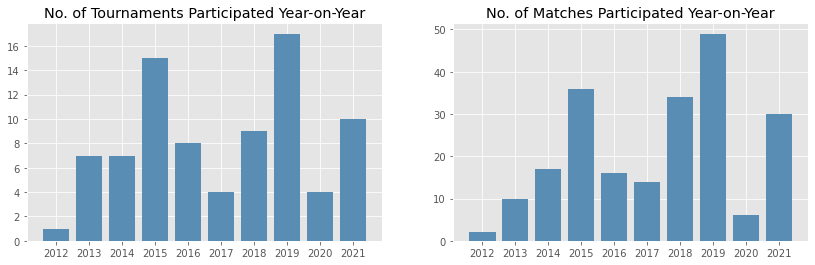

In [52]:
style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (14,4))
axes = [ax1, ax2]

for ax in axes:
    ax.set_xticks([2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021])

ax1.bar(tourney_by_year.index, tourney_by_year, color='#5a8db3')
ax1.set_title('No. of Tournaments Participated Year-on-Year')

ax2.bar(matches_by_year.index, matches_by_year, color='#5a8db3')
ax2.set_title('No. of Matches Participated Year-on-Year')
plt.show()

In [53]:
tourney_by_year.corr(matches_by_year)

0.9320849506519309

In [54]:
#values to plot line of best fit
m, b = np.polyfit(matches_by_year, tourney_by_year, 1)

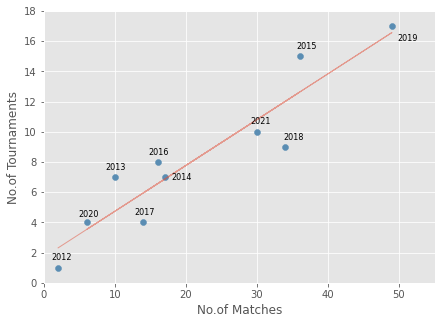

In [55]:
style.use('ggplot')
fig, ax = plt.subplots(figsize = (7,5))

ax.set_xlim(0,55)
ax.set_xlabel('No.of Matches')
ax.set_ylim(0,18)
ax.set_ylabel('No.of Tournaments')
ax.scatter(matches_by_year, tourney_by_year, color='#5a8db3')

ax.text(1, 1.5, '2012', fontsize = 8)
ax.text(8.6, 7.5, '2013', fontsize = 8)
ax.text(18, 6.8, '2014', fontsize = 8)
ax.text(35.6, 15.5, '2015', fontsize = 8)
ax.text(14.7, 8.5, '2016', fontsize = 8)
ax.text(12.8, 4.5, '2017', fontsize = 8)
ax.text(33.7, 9.5, '2018', fontsize = 8)
ax.text(49.8, 16, '2019', fontsize = 8)
ax.text(4.8, 4.4, '2020', fontsize = 8)
ax.text(29, 10.5, '2021', fontsize = 8)

ax.plot(matches_by_year, m*matches_by_year + b, linewidth = 1, alpha = 0.5, color = '#E24F39')

ax.tick_params(axis='x')
ax.tick_params(axis='y')

plt.show()

A simple hypothesis is that a player had performed better, if he had participated in more matches in any tournament (this means that the player had a deeper run into the tournament before elimination or eventually winning the final).

By plotting a line of best fit over his career, we see that Loh Kean Yew had performed better in recent years, notably in 2017 and 2018 where he had deeper runs into tournaments.

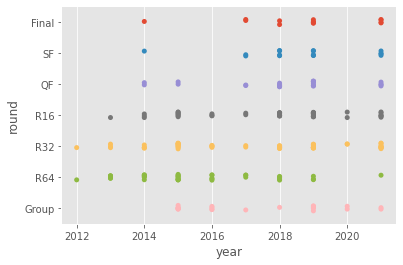

In [56]:
sns.stripplot(x='year', y='round', data=lky, order=['Final','SF','QF', 'R16', 'R32', 'R64', 'Group'])
plt.show()

### Wins and Losses <a class="anchor" id="section2.2"></a>

#### Win Rate (%) Year-on-Year

In [57]:
year_grouped = lky.groupby('year')

In [58]:
winrate_by_year = year_grouped['result'].agg(sum) / year_grouped.size() * 100
win = year_grouped['result'].agg(sum)
lose = year_grouped.size() - year_grouped['result'].agg(sum)
matches_by_year = year_grouped.size()

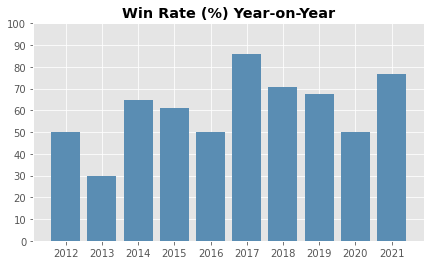

In [59]:
style.use('ggplot')
fig, ax = plt.subplots(figsize = (7,4))

ax.bar(winrate_by_year.index, winrate_by_year, color='#5a8db3')
#ax.bar(winrate_by_year.index, winrate_by_year, color=['#001219','#005F73', '#0A9396', '#94D2BD', '#E9D8A6', '#e6c76e',
                                                      #'#CA6702', '#BB3E03', '#AE2012', '#9B2226'])
ax.set_xticks([2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021])
ax.set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

ax.set_ylim(0,100)
ax.set_title('Win Rate (%) Year-on-Year', fontweight="bold")

plt.show()

Here we see that generally his win rate has been getting better over the years. 

#### Number of Wins and Losses Year-on-Year

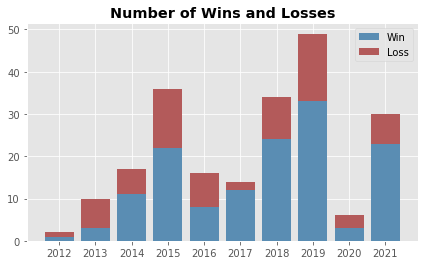

In [60]:
style.use('ggplot')
fig, ax = plt.subplots(figsize = (7,4))

ax.bar(winrate_by_year.index, win, label='Win', color='#5a8db3')
ax.bar(winrate_by_year.index, lose, bottom=win, label='Loss', color='#b35a5a')

ax.set_xticks([2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021])
ax.set_title('Number of Wins and Losses', fontweight='bold')
ax.legend()

plt.show()

We notice that the number of matches had dipped in 2016 and 2017. This had coincided when Loh Kean Yew was serving his National Service. Interestingly, he had a high win rate in 2017. However, this could also be a function of the type of tournaments he had participated in that year.

Unsurprisingly, there were very little matches played in 2020 due to the COVID-19 pandemic. 2021 had been one of the better years of win rate, and it is to be seen if his performance and form can be maintained.

#### Number of Wins and Losses by Round

In [61]:
round_grouped = lky.groupby('round')

In [62]:
winrate_by_round = (round_grouped['result'].agg(sum) / round_grouped.size() * 100).reindex(['Group','R64', 'R32', 'R16', 'QF', 'SF', 'Final'])
win_round = round_grouped['result'].agg(sum).reindex(['Group','R64', 'R32', 'R16', 'QF', 'SF', 'Final'])
lose_round = (round_grouped.size() - round_grouped['result'].agg(sum)).reindex(['Group','R64', 'R32', 'R16', 'QF', 'SF', 'Final'])

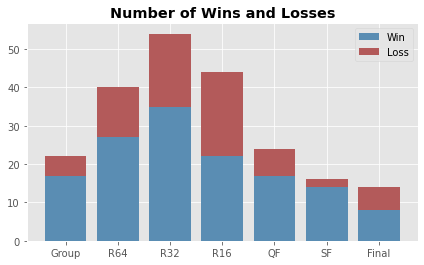

In [63]:
style.use('ggplot')
fig, ax = plt.subplots(figsize = (7,4))

ax.bar(winrate_by_round.index, win_round, label='Win', color='#5a8db3')
ax.bar(winrate_by_round.index, lose_round, bottom=win_round, label='Loss', color='#b35a5a')

ax.set_title('Number of Wins and Losses', fontweight='bold')
ax.legend()

plt.show()

From the above, we can see that Loh Kean Yew typically performs very well at the Semi-Final stage. On the other hand, he typically gets tripped up in the R32 and R64. Beyond which, he typically progresses further once he reaches the Quarter-Final stage.

We also note that as not all tournaments start from the Group or R64 stage, the number of matches in the current round may not be equivalent to the number of wins in the previous round (e.g. total wins and losses in R16 is more than the number of wins in R32).

In [64]:
lky.head()

,year,tournament,round,match_time,player1,player2,player1_set1,player2_set1,player1_set2,player2_set2,player1_set3,player2_set3,two_sets_score,set1,set2,set3,result,total_sets
0,2021,TotalEnergies BWF World Championships 2021,R64,54,LOH Kean Yew,Viktor AXELSEN,14.0,21.0,21.0,9.0,21.0,6.0,65.0,0,1,1.0,1.0,3.0
1,2021,TotalEnergies BWF World Championships 2021,R32,25,LOH Kean Yew,Luka WRABER,21.0,4.0,21.0,8.0,NaN,NaN,54.0,1,1,NaN,1.0,2.0
2,2021,TotalEnergies BWF World Championships 2021,R16,30,LOH Kean Yew,Kantaphon WANGCHAROEN,21.0,4.0,21.0,7.0,NaN,NaN,53.0,1,1,NaN,1.0,2.0
3,2021,TotalEnergies BWF World Championships 2021,QF,43,LOH Kean Yew,PRANNOY H. S.,21.0,14.0,21.0,12.0,NaN,NaN,68.0,1,1,NaN,1.0,2.0
4,2021,TotalEnergies BWF World Championships 2021,SF,61,LOH Kean Yew,Anders ANTONSEN,23.0,21.0,21.0,14.0,NaN,NaN,79.0,1,1,NaN,1.0,2.0


In [65]:
#win after dropping first set (lose-win-win)
len(lky[(lky['set1'] == 0) & (lky['result'] == 1)])

25

In [66]:
#lose after dropping first set (lose-win-lose) and (lose-lose)
len(lky[(lky['set1'] == 0) & (lky['result'] == 0)])

57

In [67]:
#lose after winning first set (win-lose-lose)
len(lky[(lky['set1'] == 1) & (lky['result'] == 0)])

17

In [68]:
#win after winning first set (win-win) and (win-lose-win)
len(lky[(lky['set1'] == 1) & (lky['result'] == 1)])

115

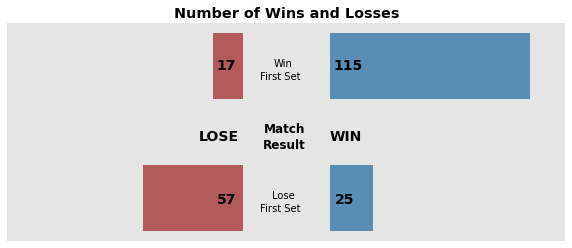

In [69]:
style.use('ggplot')
fig, ax = plt.subplots(figsize = (10,4), edgecolor='black')

x = [1,2]
y1 = [-57, -17]
y2 = [25, 115]
ax.barh(x, y1 , height = 0.5, color='#b35a5a')
ax.barh(x, y2 , height = 0.5, left=50, color='#5a8db3')
ax.set_xticklabels([])
ax.tick_params(bottom=False, left=False)
ax.set_yticklabels([])
ax.set_xlim(-135,185)

ax.text(18,2,'Win')
ax.text(10 ,1.9,'First Set')

ax.text(17,1,'Lose')
ax.text(10 ,0.9,'First Set')

ax.text(12 ,1.5,'Match', fontweight='bold', fontsize = 12)
ax.text(11.8 ,1.38,'Result', fontweight='bold', fontsize = 12)

ax.text(50 ,1.44,'WIN', fontweight='bold', fontsize = 14)
ax.text(-25 ,1.44,'LOSE', fontweight='bold', fontsize = 14)

#ax.text(145 ,1.98,'115', fontweight='bold', fontsize = 14)
ax.text(52 ,1.98,'115', fontweight='bold', fontsize = 14)
ax.text(-15 ,1.98,'17', fontweight='bold', fontsize = 14)

ax.text(53 ,0.96,'25', fontweight='bold', fontsize = 14)
ax.text(-15 ,0.96,'57', fontweight='bold', fontsize = 14)

#ax.tick_params(axis='x', colors='white')
#ax.tick_params(axis='y', colors='white')
ax.set_title('Number of Wins and Losses', fontweight='bold')
#ax.legend()
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.grid(visible=False)

plt.show()

He has a good record (87%) of building on from taking the first set to win the match, and a decent chance (30%) of a comeback victory after dropping the first set.

In [70]:
#different outcomes

#win-win
ww = len(lky[(lky['total_sets'] == 2.0) & (lky['result'] == 1.0)])

#win-lose-win
wlw = len(lky[(lky['set1'] == 1.0) & (lky['set2'] == 0.0) & (lky['result'] == 1.0)])

#lose-win-win
lww = len(lky[(lky['set1'] == 0.0) & (lky['result'] == 1.0)])

#lose-lose
#ll = len(lky[(lky['total_sets'] == 2.0) & (lky['result'] == 0)])
ll = len(lky[(lky['set1'] == 0.0) & (lky['set2'] == 0.0)])

#lose-win-lose
lwl = len(lky[(lky['set1'] == 0.0) & (lky['set2'] == 1.0) & (lky['set3'] == 0.0)])

#win-lose-lose
wll = len(lky[(lky['set1'] == 1.0) & (lky['result'] == 0.0)])

overall_result = [ww, wlw, lww, ll, lwl, wll]
print(overall_result)

[99, 16, 25, 36, 21, 17]


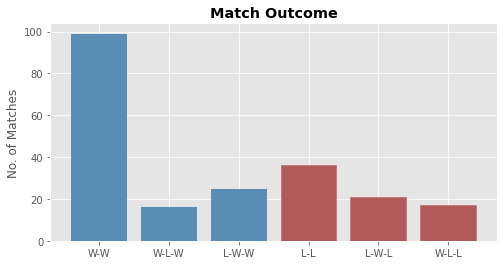

In [71]:
fig, ax = plt.subplots(figsize = (8,4))

x_label = ['W-W', 'W-L-W', 'L-W-W', 'L-L', 'L-W-L', 'W-L-L']
barlist = ax.bar(x = x_label, height=overall_result, color='#5a8db3', )

barlist[3].set_color('#b35a5a')
barlist[4].set_color('#b35a5a')
barlist[5].set_color('#b35a5a')

plt.ylabel('No. of Matches')
ax.set_title('Match Outcome', fontweight='bold')
ax.tick_params(axis='x')
ax.tick_params(axis='y')

plt.show()

He has a good record of getting the match wrapped up with straight sets victory.

## Conclusion <a class="anchor" id="chapter3"></a>

As a first-level analysis, we can see that Loh Kean Yew had generally improved over the years. For further in-depth analysis, some of the other factors to consider:
* Performance against top-rank players
* Performance in different types of [tournaments](https://en.wikipedia.org/wiki/Badminton_World_Federation#Tournaments) (different grades and levels)
* Comparing against other top players' performance